# Goal

Can I create the 7th energy level of a Quantum Harmonic Oscillator, defined by $H = \frac{P^2}{2m} + \frac{1}{2}m \omega^2 X^2$, by fine tuning the $\omega$ parameter to follow a $\omega_t$ evolution?

# Imports

In [1]:
from copy import deepcopy
from dataclasses import dataclass
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.sparse.linalg import expm
import numpy as np
import scipy
import seaborn as sns
from functools import lru_cache

plt.figure(figsize=(20,3))

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

In [2]:
@dataclass
class Settings:
    n_time_intervals:int = 5
    number_of_energy_levels:int = 10
    omega:float = 10
    resolution:int = 300
    target_energy_level:int = 6
    time_delta:float = 5 / 5 # TODO: Automatise this division
    total_evolution_time:float = 5
    x_max:float = 2
    x_min:float = -2

assert Settings.time_delta * Settings.n_time_intervals == Settings.total_evolution_time

    # @property
    # def time_delta(self):
    #     return self.total_evolution_time / self.n_time_intervals


# Setup Hamiltonian

In [3]:
valid_x = np.linspace(Settings.x_min, Settings.x_max, Settings.resolution)
delta_x = valid_x[1] - valid_x[0]
potential = lambda x: x**2

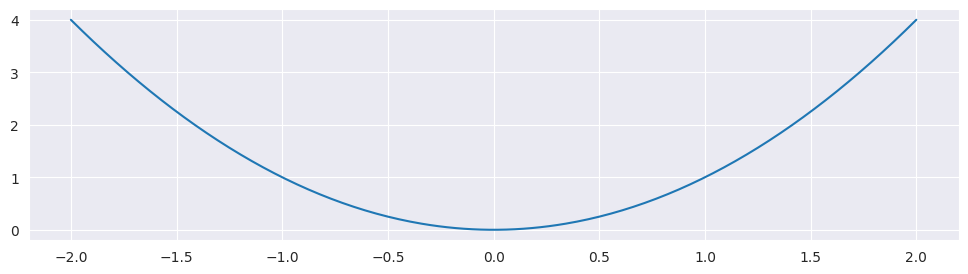

In [4]:
plt.figure(figsize=(12,3))
plt.plot(valid_x, [potential(x) for x in valid_x])

In [5]:
# Based on https://medium.com/@natsunoyuki/quantum-mechanics-with-python-de2a7f8edd1f
@lru_cache(maxsize=2*Settings.n_time_intervals)
def generate_hamiltonian(omega: float):
    # P^2 term
    temp_hamiltonian = scipy.sparse.eye(Settings.resolution, Settings.resolution, format='lil') * 2
    for i in range(Settings.resolution - 1):
        temp_hamiltonian[i, i + 1] = -1
        temp_hamiltonian[i + 1, i] = -1

    # # Turns the space cyclic. Useful for modelling ring interferometry
    # inner_hamiltonian[0, resolution - 1] = -1
    # inner_hamiltonian[resolution - 1, 0] = -1

    temp_hamiltonian = np.divide(temp_hamiltonian, delta_x ** 2)

    # V(X) term
    for i in range(Settings.resolution):
        temp_hamiltonian[i, i] = temp_hamiltonian[i, i] + omega**2 * valid_x[i]**2

    return temp_hamiltonian.tocsc()

hamiltonian = generate_hamiltonian(omega=Settings.omega)

# Energy levels

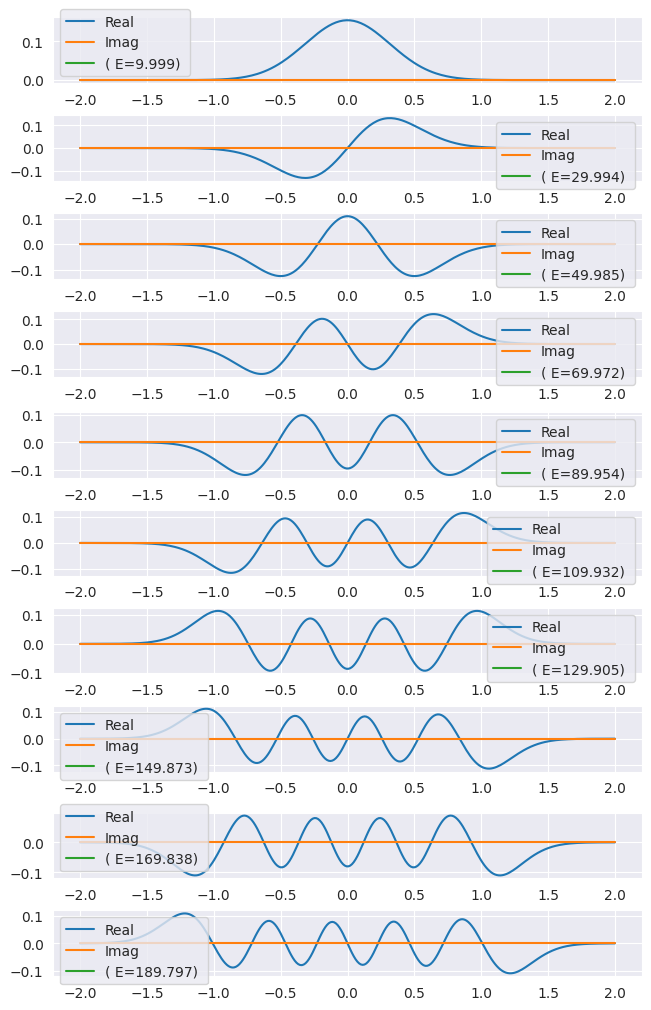

In [6]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamiltonian, k=Settings.number_of_energy_levels, which="SM")
fig, axes = plt.subplots(Settings.number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(Settings.number_of_energy_levels)
for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors.T)):
    axes[i].plot(valid_x, np.real(vector), label=f"Real")
    axes[i].plot(valid_x, np.imag(vector), label=f"Imag")
    axes[i].plot([],[], label=f"( E={np.real(val):.3f}) ")
    axes[i].legend(loc='best')

plt.show()

# Orthonormality check

<Axes: >

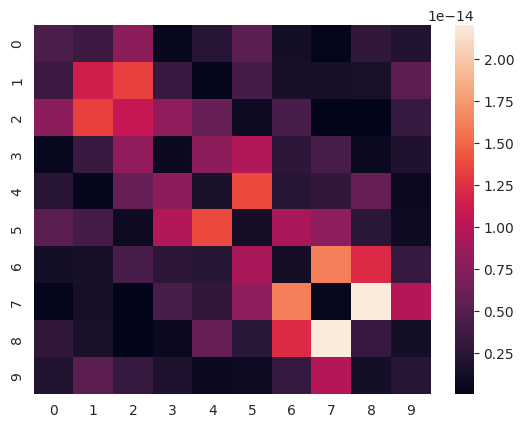

In [7]:
# Ideally this should all be zeroes
error_matrix = np.abs(eigenvectors.T @ eigenvectors) - np.eye(Settings.number_of_energy_levels)
sns.heatmap(np.abs(error_matrix))

# Origin state

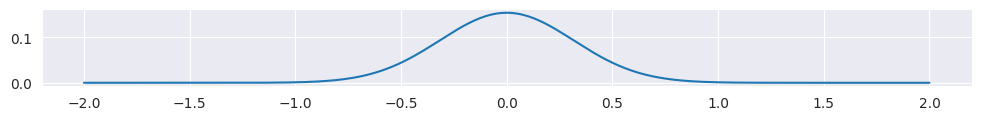

In [8]:
origin_state = eigenvectors[:, 0]
plt.figure(figsize=(12,1))
plt.plot(valid_x, np.real(origin_state))

# Target state

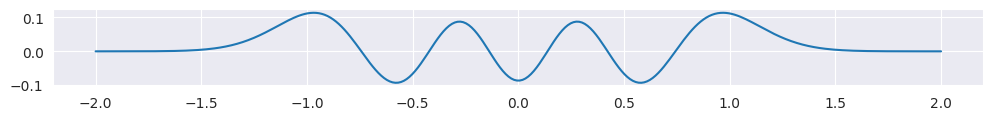

In [9]:
target_state = eigenvectors[:, Settings.target_energy_level]
plt.figure(figsize=(12,1))
plt.plot(valid_x, np.real(target_state))

In [10]:
def fidelity(state_a: np.ndarray, state_b: np.ndarray) -> float:
    return np.sum(np.abs(np.dot(state_a, state_b)) ** 2)

print(fidelity(state_a=origin_state, state_b=origin_state))
print(fidelity(state_a=target_state, state_b=target_state))
print(fidelity(state_a=origin_state, state_b=target_state))

0.9999999999999909
1.0000000000000018
1.538658263499125e-30


# Auxiliary functions

We will split the time evolution into time_intervals. We want to find a vector of time choices that maximizes the final fidelity between the target state, and the evolved state

## Fidelity
$\mathcal{F} \coloneqq |\braket{\rho_a | \rho_b} |^2$

In [11]:
def fidelity(state_a: np.ndarray, state_b: np.ndarray) -> float:
    return np.sum(
        np.abs(
            np.divide(
                np.dot(state_a, state_b),
                np.linalg.norm(state_a) * np.linalg.norm(state_b) # Normalize
            )
        ) ** 2
    )

## State evolution
$\ket{\phi_{t+s}} = e^{isH_s} \ket{\phi_t}$

In [12]:
def evolve_state(omega_list: np.array, time_list:np.array) -> np.array:
    assert len(omega_list) == len(time_list), f"The length of omega_list does not match the length of time_list: {len(omega_list)}!={len(time_list)}"
    evolved_state = deepcopy(origin_state)
    for temp_omega, temp_time in zip(omega_list, time_list):
        evolved_state = expm(-1j * generate_hamiltonian(omega=temp_omega) * temp_time) @ evolved_state
    return evolved_state

## Loss function

In [13]:
def loss(all_inputs: np.array) -> float:
    internal_omega_list, internal_time_list = np.resize(all_inputs, (2,int(len(all_inputs)/2)))
    internal_evolved_state = evolve_state(internal_omega_list, internal_time_list)
    return np.sum([
        10 * (1 - fidelity(internal_evolved_state, target_state))**2, # Fidelity
        (np.sum(internal_time_list) - Settings.total_evolution_time)**4, # Total time roughly as desired
        -1 * 10**3 * np.min([np.min(internal_time_list), 0]), # Force time to be positive
        -1 * 10**3 * np.min([np.min(internal_omega_list), 0]), # Force omega to be positive
        10**-6 * np.max(internal_omega_list)**2, # Prefer smaller omegas
        (np.linalg.norm(internal_evolved_state) - 1)**2 # Favor normalized end states
    ])

## Plotting

In [14]:
def plot_waves(omega_list: np.array, time_list: np.array, show_fidelity:bool = True) -> None:
    assert len(omega_list) == len(time_list), f"The length of omega_list does not match the length of time_list: {len(omega_list)}!={len(time_list)}"
    n_time_intervals = len(omega_list)
    evolved_state = deepcopy(origin_state)
    fig, axes = plt.subplots(n_time_intervals + 1, 1, layout='constrained')
    fig.set_figheight(n_time_intervals * 2)
    axes[0].plot(valid_x, np.real(evolved_state), label="Real")
    axes[0].plot(valid_x, np.imag(evolved_state), label="Imag")
    if show_fidelity:
        axes[0].plot([], [], label=f"$\\mathcal{{F}}={fidelity(evolved_state, target_state):.2f}$")
    axes[0].legend(loc="best")

    for i, (temp_omega, temp_time) in enumerate(zip(omega_list, time_list)):
        evolved_state = expm(-1j * generate_hamiltonian(omega=temp_omega) * temp_time) @ evolved_state
        axes[i+1].plot(valid_x, np.real(evolved_state), label="Real")
        axes[i+1].plot(valid_x, np.imag(evolved_state), label="Imag")
        axes[i+1].plot(valid_x, np.real(target_state), label="target")
        if show_fidelity:
            axes[i+1].plot([], [], label=f"$\\mathcal{{F}}={100*fidelity(evolved_state, target_state):.2f}\\%$")
            axes[i+1].plot([] , [], label=f"$\\omega={temp_omega:.2f}$")
            axes[i+1].plot([] , [], label=f"$t={temp_time:.2f}$")
        axes[i+1].legend(loc="best")

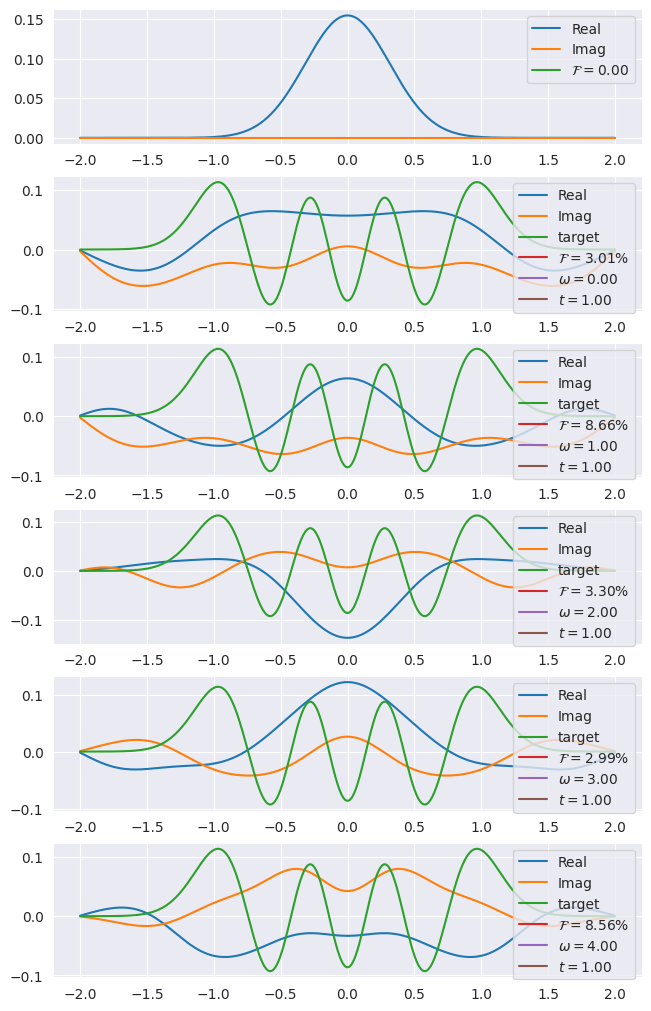

In [15]:
plot_waves(
    omega_list=range(Settings.n_time_intervals),
    time_list=np.ones(Settings.n_time_intervals)
)

# Optimization loop

In [16]:
initial_guess = np.concatenate([
    Settings.omega*np.ones(Settings.n_time_intervals) + np.divide(Settings.omega,1000) * np.random.normal(scale=1, size=Settings.n_time_intervals),
    Settings.time_delta * np.ones(Settings.n_time_intervals)
])
initial_guess

array([ 9.99109923, 10.01666573, 10.01887467, 10.01276547,  9.99591842,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

In [17]:
# TODO: GPU based solution
# https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/bfgs_minimize
results = minimize(loss, x0 = initial_guess, method="L-BFGS-B")
results

  message: ABNORMAL: 
  success: False
   status: 2
      fun: 4.88418217953985
        x: [ 1.001e+01  9.340e+00  2.923e-03  1.037e+01  9.815e+00
             1.053e+00  1.084e-06  1.940e+00  8.028e-01  9.136e-01]
      nit: 32
      jac: [-2.710e-01  0.000e+00  3.194e-03 -2.030e-02  5.773e-02
            -2.529e-02  2.401e-02  3.548e-01  6.100e-02  1.727e-01]
     nfev: 2409
     njev: 219
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

# Plots

In [18]:
omega_list, time_list = np.resize(results.x, (2,int(len(results.x)/2)))

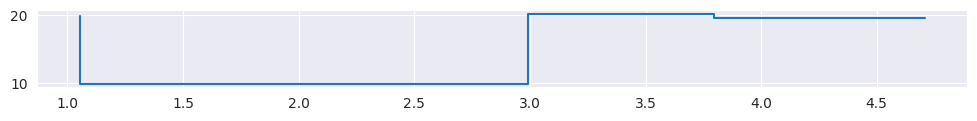

In [19]:
plt.figure(figsize=(12,1))
plt.step(x=[0] + np.cumsum(time_list), y=omega_list + [omega_list[-1]])

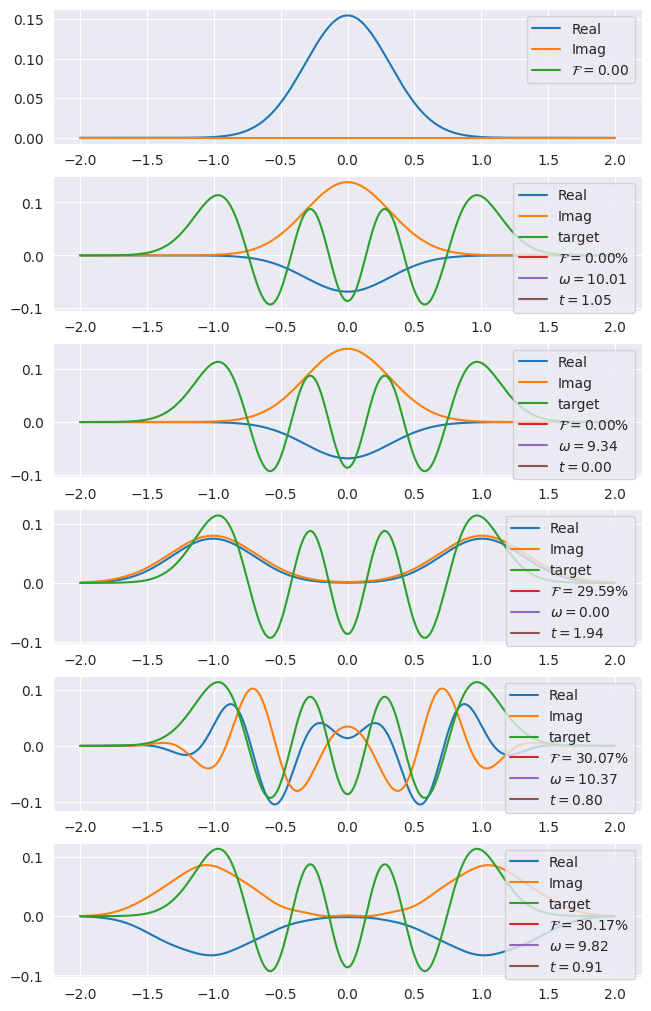

In [20]:
plot_waves(omega_list, time_list)

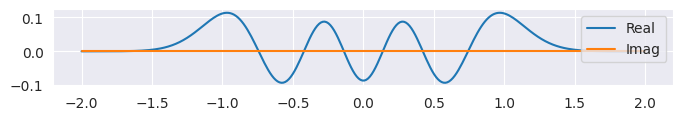

In [21]:
plt.figure(figsize=(8,1))
plt.plot(valid_x, np.real(target_state), label="Real")
plt.plot(valid_x, np.imag(target_state), label="Imag")
plt.legend(loc="best")

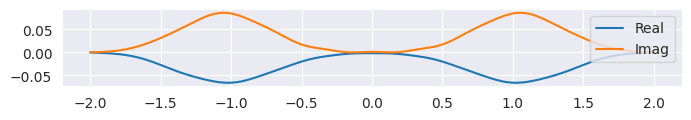

In [22]:
evolved_state = evolve_state(omega_list, time_list)
plt.figure(figsize=(8,1))
plt.plot(valid_x, np.real(evolved_state), label="Real")
plt.plot(valid_x, np.imag(evolved_state), label="Imag")
plt.legend(loc="best")